**Written by Paula Wang, October 2022**

# Introduction

This notebook is the **level 1** analysis pipeline for a psychophysiological (PPI) analysis in Nipype. PPI analysis identifies brain regions whose activity depends on an interaction between a psychological context (a task) and physiological state (the time course of brain activity) of a particular seed region. It can therefore be considered a estimation of the context-dependent changes in effective connectivity (coupling) between brain regions. 

$$Y =  (P_{SY})\beta1 + (P_{HY})\beta2 + (P_{SY} * P_{HY})\beta3 + \epsilon$$

The PPI model explains the psychological and physiological effect of one region of interest (ROI) on another, and includes an interaction term between the psychological variable and the physiological variable. In this equation, $\beta1$ and $\beta2$ are the parameter estimates for the main effects of the psychological and physiological variables respectively, $\beta3$ is the parameter estimate for their interaction $(P_{SY} * P_{HY})$, and $Y$ is the dependent variable (i.e., activation of target ROI). If the interaction term can explain the brain activation of another brain region after taking into account the main effects of the psychological and physiological variables, then the existence of a task-dependent connectivity between the two brain regions is implied.

The fitted GLM for this notebook is a variation of the PPI model above, with the main difference of an added nonlinear interaction term. 

$$ROI_T =  a*D + b*ROI_S + (c*D + d*D^2) * ROI_S + \epsilon$$

And when written out:

$$ROI_T =  a*D + b*ROI_S+ c*D*ROI_S + d*D^2*ROI_S + \epsilon$$

Therefore, we will be feeding in 4 predictors to our GLM:
1. Predictor 1 = $a*D$ = psychological event (distraction)
2. Predictor 2 = $b*ROI_S$ = physiological event (seed ROI)
3. Predictor 3 = $c*D*ROI_S$ = linear interaction term 
4. Predictor 4 = $d*D^2*ROI_S$ = non-linear interaction term 

# Initialization

**<mark>NOTE:</mark> This notebook assumes that the following processes have already been run:**
1. Fmriprep preprocessing pipeline (~/projects/thesis/code/preprocessing/preproc.ipynb)
2. Distraction pipeline (~/projects/thesis/code/distraction_regressor/prepare_distraction.ipynb)

## Docker Info

This notebook must be run within a custom-generated docker. The Dockerfile comand to replicate the analytical parameters for this analysis is below:

```
neurodocker generate docker --base ubuntu:20.04 \ 
--pkg-manager apt \ 
--install vim datalad tree \ 
--afni version=latest \ 
--ants version=2.3.1 \ 
--convert3d version=1.0.0 \ 
--dcm2niix version=latest method=source \ 
--freesurfer version=6.0.1 \ 
--copy license.txt /opt/freesurfer-6.0.1 \ 
--fsl version=6.0.4 \ 
--user=neuro \ 
--miniconda \ 
create_env=neuro \ 
conda_install="python=3.7 graphviz jupyter jupyterlab jupyter_contrib_nbextensions matplotlib nbformat nilearn numpy pandas pytest scipy seaborn sphinx sphinxcontrib-napoleon traits" \ 
pip_install="nibabel atlasreader nipype=1.6.1 neurora pybids" \ 
activate=true > Dockerfile
```

The Docker command used to run the container is below:
```
docker run -it --rm -v /home/pw/:/home/pw/ -p PORT:PORT -u pw:lab medianeuro/niflow:2.0 jupyter-lab --ip=0.0.0.0 --port=PORT
```

In [1]:
%autosave 5

Autosaving every 5 seconds


## Data Paths

In [2]:
import getpass
import os, stat

# Get current user
user = getpass.getuser()
print('Running code as: ', user)

# Set the BIDS path
data_dir = '/home/{}/projects/thesis/data/'.format(user)

# Set path where nipype will store stepwise results (e.g., masks)
exp_dir = '/home/{}/projects/thesis/out/'.format(user)

try:
    os.mkdir(exp_dir)
except OSError as error:
    print(error)
    
# Grant root write access to our output files 
os.chmod(exp_dir, os.stat(exp_dir).st_mode | ((stat.S_IRWXU | stat.S_IRWXO)))

Running code as:  pw
[Errno 17] File exists: '/home/pw/projects/thesis/out/'


In [3]:
print(f'Running data from {data_dir}')

Running data from /home/pw/projects/thesis/data/


# Workflow

Begin workflow

In [4]:
from nipype.pipeline import Workflow
from nipype.pipeline import Node, MapNode


wf_name = 'test'

wf = Workflow(name=wf_name, base_dir=exp_dir)
wf.config["execution"]["crashfile_format"] = "txt"

221016-20:12:52,467 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


Iterate over subject_id list

Documentation: [nipype.interfaces.utility.IdentityInterface](https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.utility.html#index-3)

In [5]:
from glob import glob
from nipype.interfaces.utility import IdentityInterface

subj_list = [x.split('-')[1] for x in glob(data_dir+"/bids/sub*")]
subj_list.sort()
subj_list=subj_list[:1]

ii = Node(
    interface=IdentityInterface(fields=["subject_id"]),name="ii")

ii.iterables = [("subject_id", subj_list)]

In [6]:
subj_list

['005']

## Select Data

Extract the relevant `nii.gz` and `.tsv` inputs for all subjects. 

Documentation: [nipype.interfaces.utility.DataGrabber](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#datagrabber)

In [7]:
from nipype.interfaces.io import DataGrabber

dg = Node(
    interface=DataGrabber(
        infields=["subject_id","run_id"], outfields=["func","mask","distraction","nuisance"]
    ),
    name="dg"
)

# Specify task names and return a sorted filelist to ensure we match files to correct runs/tasks
dg.inputs.run_id = ["1","2","3"]
dg.inputs.sort_filelist = True
dg.inputs.template = "*"
dg.inputs.base_directory = data_dir

# Define arguments fill the wildcards in the below paths 
dg.inputs.template_args = dict(
    func=[["subject_id","subject_id","run_id"]],
    mask=[["subject_id","subject_id","run_id"]],
    distraction=[["subject_id","subject_id","run_id"]],
    nuisance=[["subject_id","subject_id","run_id"]],    
)

# change folder location 
dg.inputs.field_template = dict(
    func="derivatives/sub-%s/func/sub-%s_task-game_run-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
    mask="derivatives/sub-%s/func/sub-%s_task-game_run-%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz",
    distraction="bids/sub-%s/func/sub-%s_task-game_run-0%s_events.txt",
    nuisance="derivatives/sub-%s/func/sub-%s_task-game_run-%s_desc-confounds_timeseries.tsv"
)

## Post-Processing

### Skull-Stripping

Mask our functional data to remove the skull.

Documentation: [nipype.interfaces.fsl.maths.ApplyMask](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.maths.html#applymask)

In [8]:
from nipype.interfaces.fsl.maths import ApplyMask

maskfunc = MapNode(
    interface=ApplyMask(), iterfield=["in_file", "mask_file"], name="apply_mask"
)

### Spatial Smoothing

In order to remain agnostic to any possible subsequent analysis, fMRIPrep does not perform any denoising (e.g., spatial smoothing) itself. FWHM is set to 6, in line with the common rule of thumb that, to render your data approximately normal, you should smooth with a Gaussian filter approximately three times the size of your voxel

Documentation: [nipype.interfaces.fsl.preprocess.SUSAN](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.preprocess.html#susan)

In [9]:
from nipype.interfaces.fsl.preprocess import SUSAN
susan = MapNode(
    interface=SUSAN(), iterfield=["in_file"], name="smooth")

susan.inputs.fwhm = 6
susan.inputs.brightness_threshold = 2000.0 # FSL standard

## Predictors

### Seed Regressors

To obtain the seed regressors to be input as our physiological predictor, we extract the neurological time series at a set of pre-determined ROIs. Our ROIs have been determined *a priori* as a set of anatomical MNI coordinates: 1. Thal [22, −27, 3] , 2. Superior frontal gyrus (SFG) [16, 4, 44], 3. Superior part of inferior frontal gyrus (IFGs)[36, 26, 15], 4. Inferior part of inferior frontal gyrus (IFGi)[34, 20, 5], 5. Lateral part of fusiform gyrus (FFGl)[44, −58, 1], 6. Medial parts of the fusiform gyrus (FFGm)[36, −60, 1], 7. Cerebellum (Cere)[0, −62, −32], 8. Middle frontal gyrus (MFG)[36, −5, 50], 9. Anterior cingulate cortex (ACC)[6, 36, 26].

fMRIprep has already warped the anatomical and functional images to the standard MNI152NLin2009cAsym template, available at https://www.templateflow.org/usage/archive/. 

Documentation: [nipype.interfaces.utility.Function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.utility.wrappers.html) and [example use](https://nipype.readthedocs.io/en/0.11.0/users/function_interface.html)

In [1]:
from nipype.interfaces.utility import Function

def seedmask(func_file):
    coords = [(22, -27, 3),(16, 4, 44),(36, 26, 15),(34, 20, 5),(44, -58, 1),(36, -60, 1),(0, -62, -32),(36, -5, 50),(6, 36, 26)]
    seed_masker = hiftisp(coords, radius=3, detrend=True,
                                     high_pass=None, t_r=2.,standardize=False,
                                     memory='nilearn_cache',
                                     memory_level=1, verbose=0)
    seed_time_series = seed_masker.fit_transform(func_file)
    return seed_time_series

seedmask = MapNode(
    Function(
    function=seedmask, input_names=["func_file"], output_names=["seed_time_series"]
    ),
    name="seedmask", iterfield=["func_file"]
)

ModuleNotFoundError: No module named 'nipype'

### Distraction Regressor

This notebook assumes that the notebook for calculating our distraction regressor has already been run (~/projects/thesis/code/distraction_regressor/prepare_distraction.ipynb). The output was saved into the bids file structure of each subject for each run, under `events.txt`.

### Nuisance Regressors

For de-noising, we went with a set of nine nuisance regressors, including six realignment parameters (three rotations and three translations), two physiological (white matter and csf), and global signal regression. This is a set of nuisance regressors that has been widely applied to functional connectivity studies [(Ciric et al., 2017)](https://doi.org/10.1016/j.neuroimage.2017.03.020).

In [11]:
def get_predictors(seed_time_series, dist_file, nr_file, roi):
    import numpy as np
    import pandas as pd
    from scipy.stats import zscore
    from nilearn.glm.first_level import compute_regressor

    # Prepare timings
    t_r = 2.
    slice_time_ref = 0.
    n_scans = 185
    frametimes = np.linspace(0, (n_scans - 1) * t_r, n_scans)

    # Prepare psy
    distraction = pd.read_csv(dist_file, header=None)[0][10:-55]
    distraction_df = pd.DataFrame(
        {
        'dist': distraction - distraction.mean(), # mean-centered
        'distsq': distraction**2 - (distraction**2).mean() # mean-centered and squared
        }).reindex(range(185), fill_value=0)
    
    for column in distraction_df:
        onset, duration, amplitude = list(range(0, 370, 2)), [2]*185, distraction_df[column]
        exp_condition = np.array((onset, duration, amplitude)).reshape(3, 185)
        distraction_conv = compute_regressor(exp_condition=exp_condition, 
                                             hrf_model='spm', # convolution hrf
                                             frame_times=frametimes, 
                                             con_id=column)
        data, colname = distraction_conv[0], distraction_conv[1][0]+'_conv'
        distraction_df = pd.concat([distraction_df, pd.DataFrame(data, columns=[colname])], axis=1) 

    # Prepare seed
    seed = pd.DataFrame(seed_time_series,columns=['Thal','SFG','IFGs','IfGi','FFGl','FFGm','Cere','MFG','ACC']) 
    seed_mc = seed-seed.mean() # mean-centered
    seed_df = seed_mc[[roi]]

    # Prepare interactions
    interactions_df = pd.DataFrame({roi+'_dist': seed_df[roi]*distraction_df['dist_conv'],
                                    roi+'_distsq':seed_df[roi]*distraction_df['distsq_conv']})

    # Prepare nuisance regressors
    nr_labels = ['global_signal','white_matter','csf','rot_x','rot_y','rot_z','trans_x','trans_y','trans_z']
    nuisance = pd.read_csv(nr_file, sep='\t', usecols=nr_labels)
    nuisance_df = nuisance - nuisance.mean() # mean-centered

    # get conditions df
    conditions = pd.DataFrame()
    conditions = pd.concat([conditions, distraction_df[['dist_conv']], seed_df, interactions_df], axis=1)
    
    return conditions, nuisance_df

get_predictors = MapNode(
    Function(
    function=get_predictors, input_names=["seed_time_series", "dist_file", "nr_file", "roi"], output_names=["conditions", "regressors"]
    ),
    name="get_predictors", iterfield=["seed_time_series", "dist_file", "nr_file"]
)
                     
get_predictors.iterables = ("roi",['Thal','SFG','IFGs','IfGi','FFGl','FFGm','Cere','MFG','ACC'])

## Level 1 Model

### Run Info and Contrast List

The `modelgen.SpecifyModel()` interface is Nipype's custom GLMmodel generator. It takes a list of event files as input, which is calculated with out `get_subjinfo` function. We need to combine our prepared predictors and nuisance regressors into a single bunch file. Therefore, we need to generate a `Bunch function` that includes all subject and run information. Since we have three runs, we have three bunch functions per subject. This will be used as the `subject_info` input in the `modelspec` node. 

Documentation: [nipype.interfaces.base.Bunch](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.base.support.html)

In [12]:
def get_subjinfo(conditions, regressors):
    from os.path import join as opj
    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    run_info = Bunch(onsets=[], durations=[])
    run_info.set(conditions = conditions.columns.tolist())
    for cond in conditions.columns.tolist():
        run_info.onsets.append(list(range(0,370,2))) # in seconds
        run_info.durations.append([2]*185) # in seconds
    run_info.set(amplitudes = conditions.T.values.tolist())    
    run_info.set(regressor_names = regressors.columns.tolist())
    run_info.set(regressors = regressors.T.values.tolist())

    subj_info = []
    subj_info.append(run_info)
    
    condition_names = conditions.columns.tolist()
    cont01 = [condition_names[0], "T", condition_names, [1, 0, 0, 0]] # dist_conv
    cont02 = [condition_names[1], "T", condition_names, [0, 1, 0, 0]] # ROI
    cont03 = [condition_names[2], "T", condition_names, [0, 0, 1, 0]] # ROI_dist
    cont04 = [condition_names[3], "T", condition_names, [0, 0, 0, 1]] # ROI_distsq
    contrast_list = [cont03, cont04] #only need the contrasts for the c and d coefficients

    return subj_info, contrast_list

get_subjinfo = MapNode(
    Function(
    function=get_subjinfo, input_names=["conditions","regressors"], output_names=["subj_info", "contrast_list"]
    ),
    name="get_subjinfo", iterfield = ["conditions","regressors"]
)

### Model Specification

Documentation: [nipype.algorithms.modelgen.SpecifyModel](https://nipype.readthedocs.io/en/latest/api/generated/nipype.algorithms.modelgen.html)

In [13]:
from nipype.algorithms.modelgen import SpecifyModel

modelspec = MapNode(
    interface=SpecifyModel(), 
    name="modelspec", iterfield=["functional_runs","subject_info"]
)

highpass=100 #in seconds
TR=2

modelspec.inputs.high_pass_filter_cutoff = highpass 
modelspec.inputs.input_units = "secs"
modelspec.inputs.time_repetition = TR

### Design File

Generate an FSL design.fsf file as input for FSL's FEAT. 

Documentation: [nipype.interfaces.fsl.model.Level1Design](https://nipype.readthedocs.io/en/1.8.3/api/generated/nipype.interfaces.fsl.model.html#level1design)

In [14]:
from nipype.interfaces.fsl.model import Level1Design

level1design = MapNode(
    Level1Design(), name="level1design", iterfield=["session_info","contrasts"]
)

level1design.inputs.interscan_interval = TR

# Set HRF bases functions
level1design.inputs.bases = {'none':{None:None}}
level1design.inputs.model_serial_correlations = True

### Design Matrix 

Documentation: [nipype.interfaces.fsl.model.FEATModel](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#featmodel)

In [15]:
from nipype.interfaces.fsl.model import FEATModel

modelgen = MapNode(
    FEATModel(), name='modelgen', iterfield=['fsf_file', 'ev_files'])

## Analysis

Documentation: [nipype.interfaces.fsl.model.FILMGLS](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#filmgls)

In [16]:
from nipype.interfaces.fsl.model import FILMGLS

level1estimate = MapNode(
    FILMGLS(smooth_autocorr=True, mask_size=5, threshold=1000), name='level1estimate', iterfield=['design_file', 'in_file', 'tcon_file'])

# Connnect Workflow

In [17]:
wf.connect([
    # get data
    (ii, dg, 
     [("subject_id", "subject_id")]),
    # smoothing 
    (dg, susan, 
     [("func", "in_file")]),
    # seed mask
    (susan, seedmask, 
     [("smoothed_file","func_file")]),
    # get predictors
    (seedmask, get_predictors,
     [("seed_time_series","seed_time_series")]),
    (dg, get_predictors, 
     [("distraction","dist_file"), 
      ("nuisance", "nr_file")]),
    # get subject info
    (get_predictors, get_subjinfo,
     [("conditions","conditions"),
      ("regressors","regressors")]),
    # specify model
    (get_subjinfo, modelspec,
     [("subj_info","subject_info")]),
    (susan, modelspec,
     [("smoothed_file","functional_runs")]),
    # create design fsf files
    (modelspec, level1design,
     [("session_info","session_info")]),
    (get_subjinfo, level1design,
     [("contrast_list","contrasts")]),
    # feat model
    (level1design, modelgen, 
     [('fsf_files', 'fsf_file'), 
      ('ev_files','ev_files')]),
    # parameter estimates
    (susan, level1estimate,
     [('smoothed_file', 'in_file')]),
    (modelgen, level1estimate,
     [('design_file','design_file'),
      ('con_file','tcon_file')]),
])

## Visualize Workflow

221016-20:12:53,660 nipype.workflow INFO:
	 Generated workflow graph: /home/pw/projects/thesis/out/test/modelfit_final_detailed.png (graph2use=exec, simple_form=False).


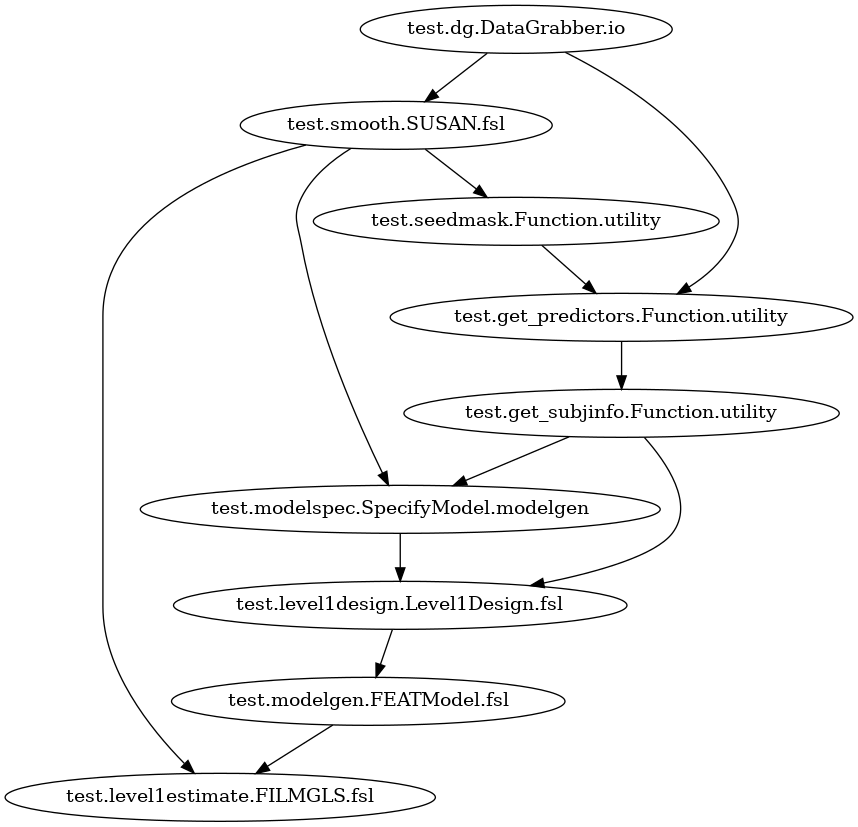

In [18]:
wf.write_graph(
    graph2use="exec", format="png", simple_form=False, dotfilename="modelfit_final.dot"
)

# # Visualize the graph
from IPython.display import Image

Image(
    filename=exp_dir + f"/{wf_name}/modelfit_final.png", width=1500, height=1500
)

# Run

In [19]:
wf.run() #plugin="MultiProc", plugin_args={"n_procs": 8}

221016-20:12:53,683 nipype.workflow INFO:
	 Workflow test settings: ['check', 'execution', 'logging', 'monitoring']
221016-20:12:53,765 nipype.workflow INFO:
	 Running serially.
221016-20:12:53,766 nipype.workflow INFO:
	 [Node] Setting-up "test.dg" in "/home/pw/projects/thesis/out/test/_subject_id_005/dg".
221016-20:12:53,781 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
221016-20:12:53,785 nipype.workflow WARNING:
	 Storing result file without outputs
221016-20:12:53,788 nipype.workflow WARNING:
	 [Node] Error on "test.dg" (/home/pw/projects/thesis/out/test/_subject_id_005/dg)
221016-20:12:53,790 nipype.workflow ERROR:
	 Node dg.b0 failed to run on host 9d7619b5928a.
221016-20:12:53,791 nipype.workflow ERROR:
	 Saving crash info to /home/pw/projects/thesis/code/3_analysis/crash-20221016-201253-pw-dg.b0-3257ff4d-8a5c-4649-b9e9-2c93ed157fb0.txt
Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipy

RuntimeError: Workflow did not execute cleanly. Check log for details